:<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lightweight_mmm/blob/main/examples/end_to_end_demo_with_multiple_geos.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lightweight_mmm/blob/main/examples/end_to_end_demo_with_multiple_geos.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# End to End Demo with Multiple Geos

Welcome to the end to end demo of LightweightMMM, with multiple geos. This is a very simple demo in which we showcase the basic usage and functionalities of the library.

Disclaimer: This notebook skips all exploratory data analysis and preprocessing (besides scaling) and assumes the user will do or has done it prior to engaging this point of the demo.

This notebook uses dummy data and therefore the numbers and results might not be representative of what one might get on a real dataset. 

This notebook is nearly identical to the simple_end_to_end_demo notebook, but uses multiple geos to showcase that functionality.

For running chains in parallel you can set the number of CPUs at the begining of the program like the following:
`numpyro.set_host_device_count(n)`

In [1]:
# First would be to install lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-266e7pn5
  Running command git clone -q https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-266e7pn5


In [2]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

In [3]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Organising the data for modelling

In [4]:
SEED = 105

In [5]:
data_size = 104 + 13
n_media_channels = 3
n_extra_features = 1
n_geos = 2

In [6]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features,
    geos=n_geos)

We can then split the dataset into train and test. Lets leave only the last 13 weeks for testing in this case. Note that this train/test split looks exactly the same as the notebook without multiple geos.

In [7]:
# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Scaling is essential for many modelling problems and this one is no exception.

We provide the class `CustomScaler` which behaves accordingly with `sklearn`
scalers.

In most cases you will need 3 or 4 scalers. One scaler for the media data, one
for the target and one for costs. Optionally if you are adding extra features
those might need an extra scaler. **It is very important that you save and
"carry with you" those scalers throughout your MMM journey as LighweightMMM will
allow you to re-insert these scalers at different points to ensure everything is
always in the correct scale and results. If some results don't make sense, it
might be a scaling problem.**

A few more details on CustomScaler usage:

This scaler can be used in two fashions for both the multiplication and division
operation. 
- By specifying a value to use for the scaling operation. 
- By specifying an operation used at column level to calculate the value for the
actual scaling operation.

Eg. if one wants to scale the dataset by multiply by 100 you can directly pass
multiply_by=100. Value can also be an array of an appropriate shape by which
to divide or multiply the data. But if you want to multiply by the mean value of each
column, then you can pass multiply_operation=jnp.mean (or any other operation
desired).

Operation parameters have the upper hand in the cases where both values and
operations are passed, values will be ignored in this case.

Consult the full class documentation if you still need to know more.

In [8]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

### Training the model

The currently available models are the following: 
- hill_adstock 
- adstock 
- carryover

In [9]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

Training the model will require the following mandatory parameters: 
- media
- total_costs (one value per channel) 
- target

We can optionally also pass the following: 
- extra_features: Other variables to add to the model. 
- degrees_seasonality: Number of degrees to use for seasonality. Default is 3. 
- seasonality_frequency: Frequency of the time period used. Default is 52 as in 52 weeks per year. 
- media_names: Names of the media channels passed. 
- number_warmup: Number of warm up samples. Default is 1000. 
- number_samples: Number of samples during sampling. Default is 1000. 
- number_chains: Number of chains to sample. Default is 2.

In [10]:
number_warmup=1000
number_samples=1000

In [11]:
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED)

/usr/local/lib/python3.7/dist-packages/lightweight_mmm/lightweight_mmm.py:256: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  num_chains=number_chains)
sample: 100%|██████████| 2000/2000 [02:58<00:00, 11.24it/s, 511 steps of size 6.22e-03. acc. prob=0.94]


You can check the summary of your trace by printing a summary:

In [12]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.52      0.30      0.54      0.10      1.00   1988.28      1.00
ad_effect_retention_rate[1]      0.29      0.15      0.28      0.03      0.52   1176.68      1.00
ad_effect_retention_rate[2]      0.26      0.20      0.22      0.00      0.54    904.49      1.00
    channel_coef_media[0,0]      0.03      0.09      0.01      0.00      0.07   1605.12      1.00
    channel_coef_media[1,0]      0.37      0.31      0.27      0.06      0.76   1163.45      1.00
    channel_coef_media[2,0]      0.24      0.27      0.16      0.00      0.56    665.77      1.00
   coef_extra_features[0,0]      0.02      0.01      0.02      0.00      0.04   1449.00      1.00
   coef_extra_features[0,1]      0.03      0.01      0.03      0.01      0.05   1308.18      1.00
            coef_media[0,0]      0.01      0.01      0.00      0.00      0.02   1795.06      1.00
            coef_me

We can visualise the posterior distributions of the media effects, one for each channel-geo combination.

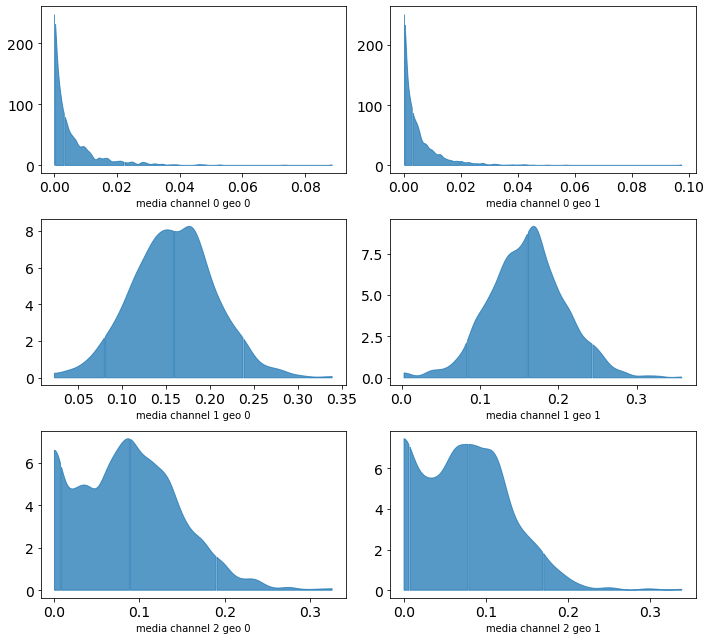

In [13]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

One can also check your model's fit to the training data, one plot per geo.

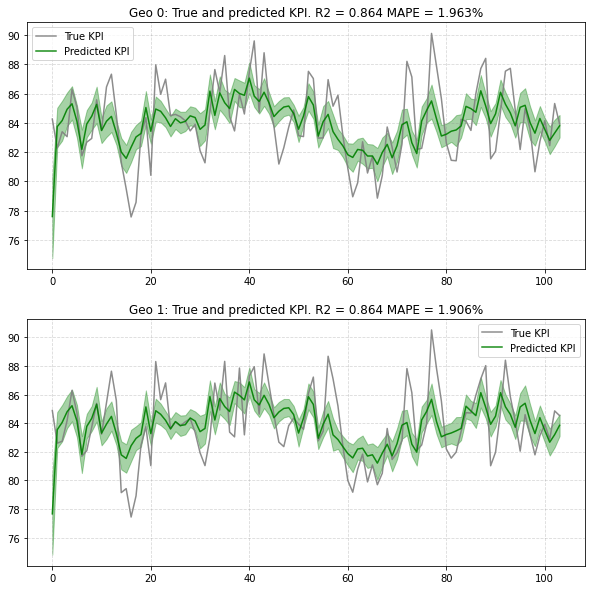

In [14]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

If one wants to run predictions on unseen data they can rely on the `predict`
method:

In [15]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13, 2)

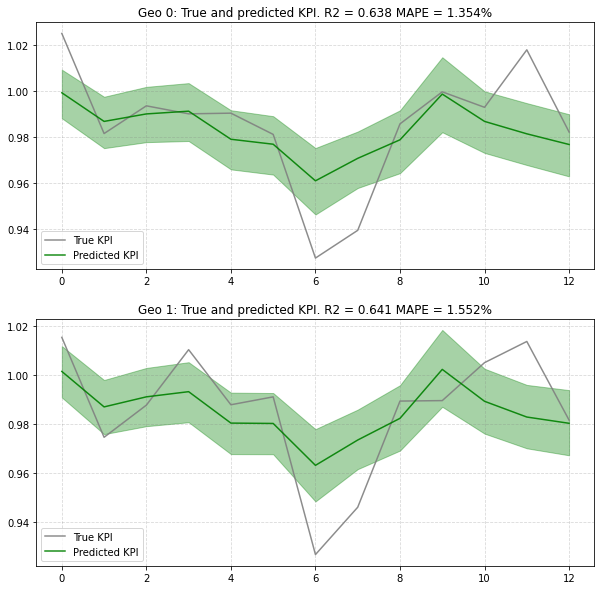

In [16]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

### Media insights

In [17]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

We can quickly visualise the estimated media contributions with their respective
credibility intervals.

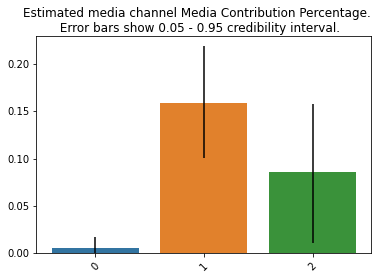

In [18]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

We can quickly visualise the estimated media & baseline contribution over time

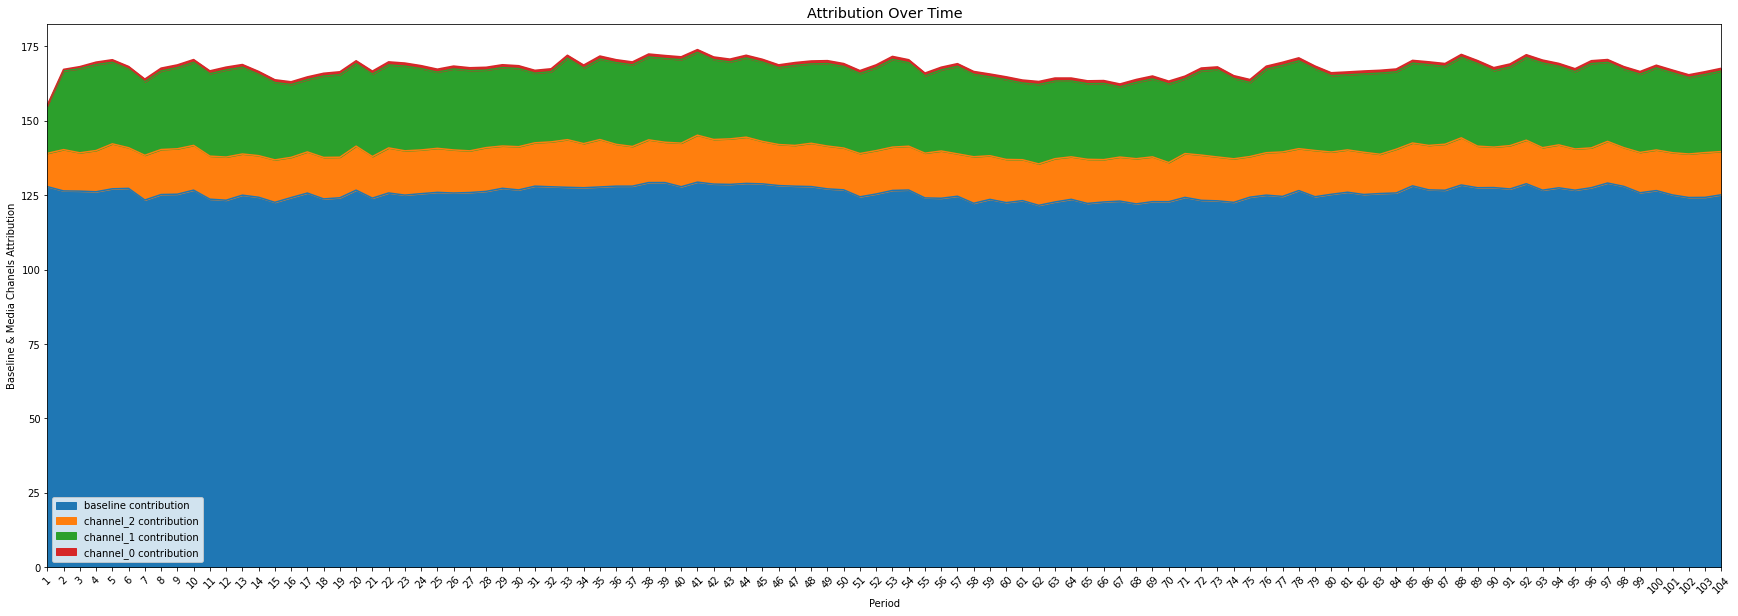

In [19]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

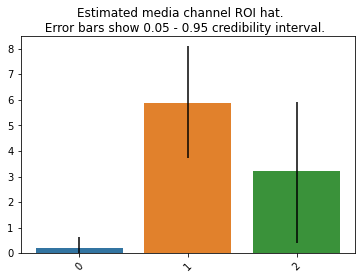

In [20]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

Another vital question we can solve with MMMs is how each media channel behaves
individually as we invest more in it.

For that we can plot the curve response of all media channels with the following
function:

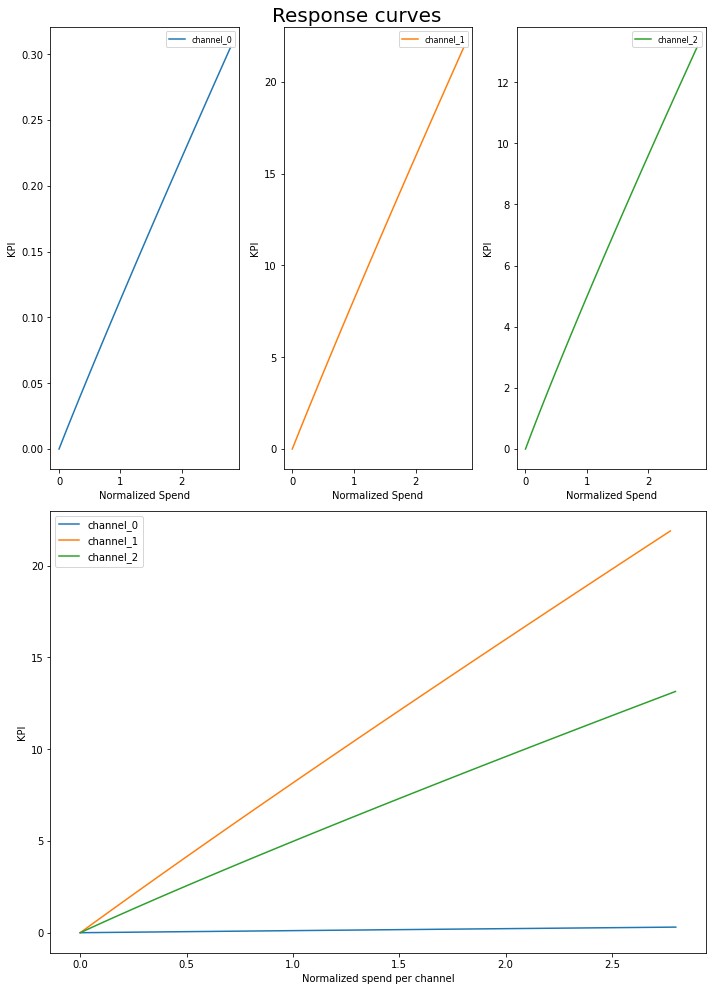

In [21]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Optimization

The optimization is meant to solve the budget allocation questions for you. Note that the optimization is done at a national level, not a geo level, since we typically use MMMs to inform channel-level decisions at a high level.

First you need to provide for how long you want to optimize your budget (eg. 15
weeks in this case).


The optimization values will be bounded by +- 20% of the max and min historic
values used for training. Which means the optimization won't recommend to
completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters: -
bounds_lower_pct - bounds_upper_pct

Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each
channel. If your data is already a money unit (eg. $) your prices should be an
array of 1s.

In [22]:
prices = jnp.ones(mmm.n_media_channels)

The budget is how much one would like to allocate throughtout the total of
`n_time_periods`. Make sure this amount is inline with the historic spend or
otherwise some conditions/bounds in the optimization might not be met.

In [23]:
n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [24]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1661.761484326038
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14


In [25]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

DeviceArray([377.73602, 557.96484, 269.06085], dtype=float32)

In [26]:
# Both values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(DeviceArray(1204.7617, dtype=float32), DeviceArray(1204.7617, dtype=float32))

We can double check the budget constraint was met:

In [27]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(DeviceArray(1204.7617, dtype=float32), DeviceArray(1204.7617, dtype=float32))

## We can plot the following:
1. Pre post optimization budget allocation comparison for each channel
2. Pre post optimization predicted target variable comparison

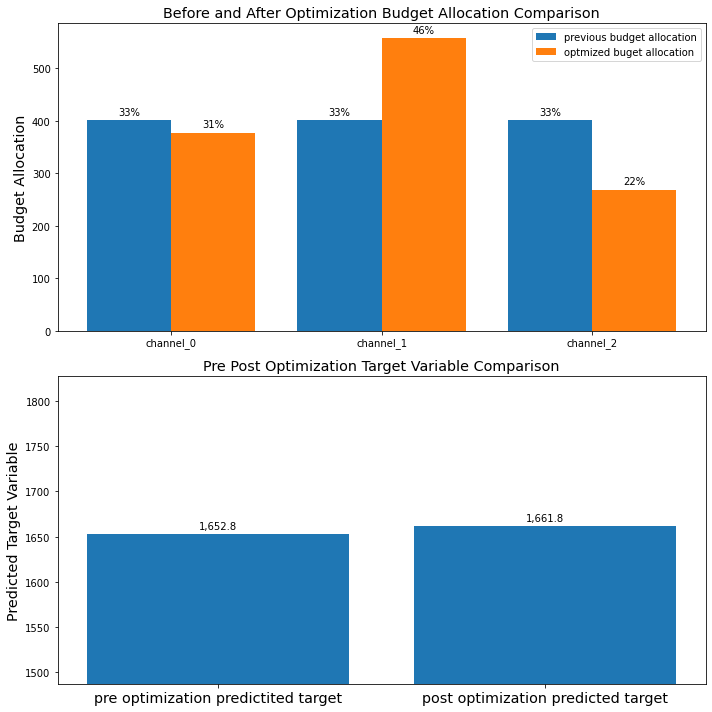

In [28]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))

## Saving the model to disk

In [29]:
# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

In [30]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path=file_path)
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 3, 2)